In [1]:
from __future__ import division, print_function
%matplotlib inline
import sys
sys.path.insert(0,'..') # allow us to format the book
sys.path.insert(0,'../kf_book') 
# use same formattibng as rest of book so that the plots are
# consistant with that look and feel.
import book_format
#book_format.load_style(directory='..')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn, random, uniform, seed
import scipy.stats

class ParticleFilter(object):

    def __init__(self, N, x_dim, y_dim):
        self.particles = np.empty((N, 3))  # x, y, heading
        self.N = N
        self.x_dim = x_dim
        self.y_dim = y_dim

        # distribute particles randomly with uniform weight
        self.weights = np.empty(N)
        self.weights.fill(1./N)
        self.particles[:, 0] = uniform(0, x_dim, size=N)
        self.particles[:, 1] = uniform(0, y_dim, size=N)
        self.particles[:, 2] = uniform(0, 2*np.pi, size=N)


    def predict(self, u, std):
        """ move according to control input u with noise std"""

        self.particles[:, 2] += u[0] + randn(self.N) * std[0]
        self.particles[:, 2] %= 2 * np.pi

        d = u[1] + randn(self.N)
        self.particles[:, 0] += np.cos(self.particles[:, 2]) * d
        self.particles[:, 1] += np.sin(self.particles[:, 2]) * d

        self.particles[:, 0:2] += u + randn(self.N, 2) * std


    def weight(self, z, var):
        dist = np.sqrt((self.particles[:, 0] - z[0])**2 +
                       (self.particles[:, 1] - z[1])**2)

        # simplification assumes variance is invariant to world projection
        n = scipy.stats.norm(0, np.sqrt(var))
        prob = n.pdf(dist)

        # particles far from a measurement will give us 0.0 for a probability
        # due to floating point limits. Once we hit zero we can never recover,
        # so add some small nonzero value to all points.
        prob += 1.e-12
        self.weights += prob
        self.weights /= sum(self.weights) # normalize


    def neff(self):
        return 1. / np.sum(np.square(self.weights))


    def resample(self):
        p = np.zeros((self.N, 3))
        w = np.zeros(self.N)

        cumsum = np.cumsum(self.weights)
        for i in range(self.N):
            index = np.searchsorted(cumsum, random())
            p[i] = self.particles[index]
            w[i] = self.weights[index]

        self.particles = p
        self.weights.fill(1.0 / self.N)


    def estimate(self):
        """ returns mean and variance """
        pos = self.particles[:, 0:2]
        mu = np.average(pos, weights=self.weights, axis=0)
        var = np.average((pos - mu)**2, weights=self.weights, axis=0)

        return mu, var

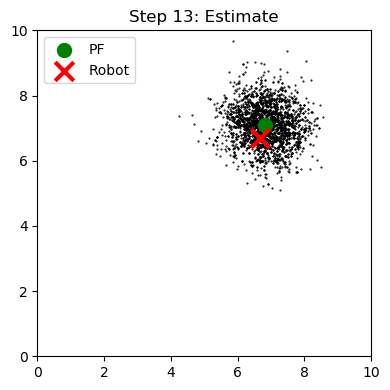

In [3]:
from pf_internal import plot_pf

seed(1234)
N = 3000
pf = ParticleFilter(N, 20, 20)
xs = np.linspace (1, 10, 20)
ys = np.linspace (1, 10, 20)
zxs = xs + randn(20)
zys = xs + randn(20)

def animatepf(i):
    if i == 0:
        plot_pf(pf, 10, 10, weights=False)
        
    idx = int((i-1) / 3)
    x, y = xs[idx], ys[idx]
    z = [x + randn()*0.2, y + randn()*0.2]

    step = (i % 3) + 1
    if step == 2:
        pf.predict((0.5, 0.5), (0.2, 0.2))
        pf.weight(z=z, var=.6)
        plot_pf(pf, 10, 10, weights=False)
        plt.title('Step {}: Predict'.format(idx+1))
    elif step == 3:
        pf.resample()
        plot_pf(pf, 10, 10, weights=False)
        plt.title('Step {}: Resample'.format(idx+1))

    else:
        mu, var = pf.estimate()
        plot_pf(pf, 10, 10, weights=False)
        plt.scatter(mu[0], mu[1], color='g', s=100, label='PF')
        plt.scatter(x, y, marker='x', color='r', s=180, lw=3, label='Robot')
        plt.title('Step {}: Estimate'.format(idx+1))
        #plt.scatter(mu[0], mu[1], color='g', s=100, label="PF")
        #plt.scatter([x+1], [x+1], marker='x', color='r', s=180, label="True", lw=3)
        plt.legend(scatterpoints=1, loc=2)
    plt.tight_layout()

from gif_animate import animate
animate('particle_filter_anim.gif', animatepf, 
        frames=40, interval=800, figsize=(4, 4))

<img src='particle_filter_anim.gif'>